## Step1. Building the Model

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#!unzip -qq "/content/archive.zip"

### Setup  
Before we proceed, we have to import the necessary libraries.

In [3]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

### Configure GPU
Secondly, let’s configure our GPU options. If there is a GPU available, this snippet detects it and sets the device to GPU.

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


### File System
Now, let’s proceed to tidy up our file system locations.

In [5]:
root_path = 'C:/Users/Geun\Google Drive/(2021) 3학년 하계방학/MIL_스터디/Semantic Segmentation in Self-driving Cars/archive/cityscapes_data/'


In [6]:
data_dir = root_path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


### Sample Image Retrieval
Now that we’ve established a file path, let’s fetch a sample image and see if the retrieval process works fine.


C:/Users/Geun\Google Drive/(2021) 3학년 하계방학/MIL_스터디/Semantic Segmentation in Self-driving Cars/archive/cityscapes_data/train\1.jpg


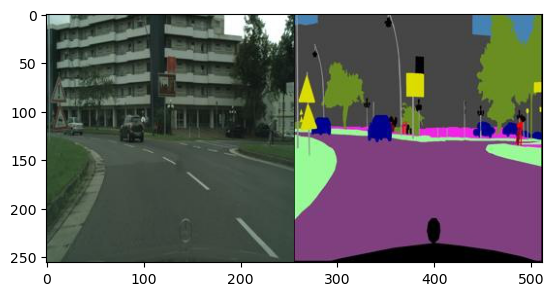

In [7]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

plt.show(sample_image)

### Define Output Labels
We now define the labels in the output image. Ideally, every pixel of the input image is annotated and assigned labels by hand. Since we already have the color-coded output image, we just need to segregate these colors as different labels. 
  
I have used a simple K-means algorithm to give these colored labels into 10 different classes. This will be the ground truth by proxy for our model.  
  
To train our clustering model, we initialize color_array, which is a randomly initialized matrix.  
  
Ground Truth는 추론을 통해 제공되는 정보가 아닌 직접 관찰 및 측정을 통해 제공되는 실제 또는 사실로 알려진 정보를 지칭하기 위해 다양한 분야에서 사용되는 용어입니다.

In [8]:
num_items = 1000

# 0~255 숫자를 3*num_items번 랜덤하게 뽑기
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [9]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [10]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

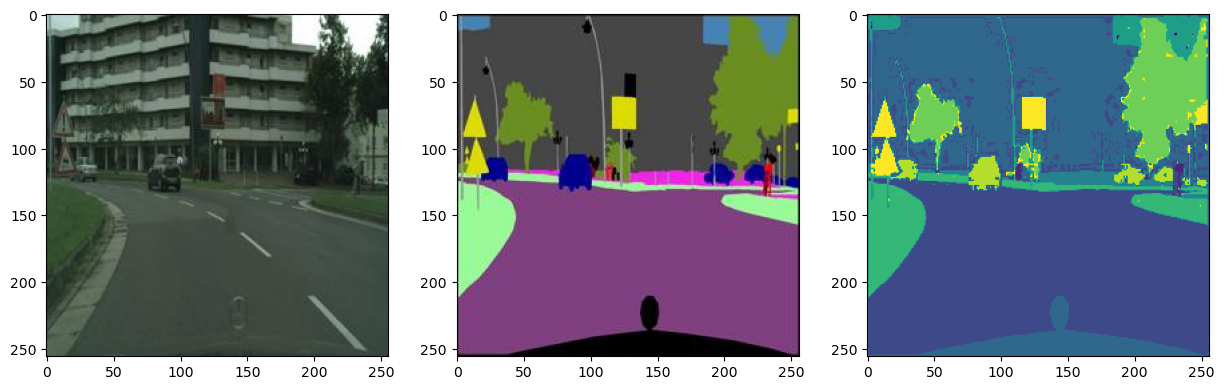

In [11]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [12]:
label.reshape(-1,3).shape

(65536, 3)

In [13]:
label_model.predict(label.reshape(-1,3)).shape

(65536,)

### Define the Dataset
We define the class CityscapeDataset, which acts as an iterator that returns a single input road scene image X and its corresponding label image Y. This vital function is carried out by the function__getitem__(). Furthermore, the image is normalized using the transform() function. This reduces the impact that any single channel (R, G, B) can have on the activations and eventually outputs.

In [14]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [15]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [16]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


### The U-Net Model  
The end-end model which we are going to use is the UNet model. In a naive image classification task, the primary objective is to convert the input feature map into a vector. However, in semantic segmentation, we have to reconstruct an image from this vector as well. That’s where UNet comes into the picture. We use the same feature mapping that helped us convert the feature map into the vector, to perform the reverse function. Thus, we have the contracting block and the expansive block.

In [17]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [18]:
model = UNet(num_classes=num_classes)

In [19]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [20]:
Y_pred = model(X)
print(Y_pred.shape)

C:\Users\Geun\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([4, 10, 256, 256])


Voila! The model has been created. Let’s proceed to train the model. To get a more comprehensive view of the model, check out this article.

## Step 2. Training the model
We train the model for 10 epochs using a learning_rate of 0.01. Further, we use the CrossEntropyLoss and Adamoptimizer to evaluate the model and guide the gradients through the state space respectively.

In [21]:
batch_size = 10

epochs = 10
lr = 0.01

In [22]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [23]:
model = UNet(num_classes = num_classes).to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [25]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Let’s plot the training losses to observe the trend.

In [36]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_loss)

Let’s save the model and move on to the model predictions section.

In [37]:
model_name = "UNet.pth"
torch.save(model.state_dict(), root_path + model_name)

## Step 3. Check model predictions
We load the saved model and fetch the test set. We then iterate through the set and predict the new, unseen images.

In [38]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [39]:
model_path = root_path + model_name
model_ = UNet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [54]:
test_batch_size = 5
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [55]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([5, 10, 256, 256])
torch.Size([5, 256, 256])


In [56]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


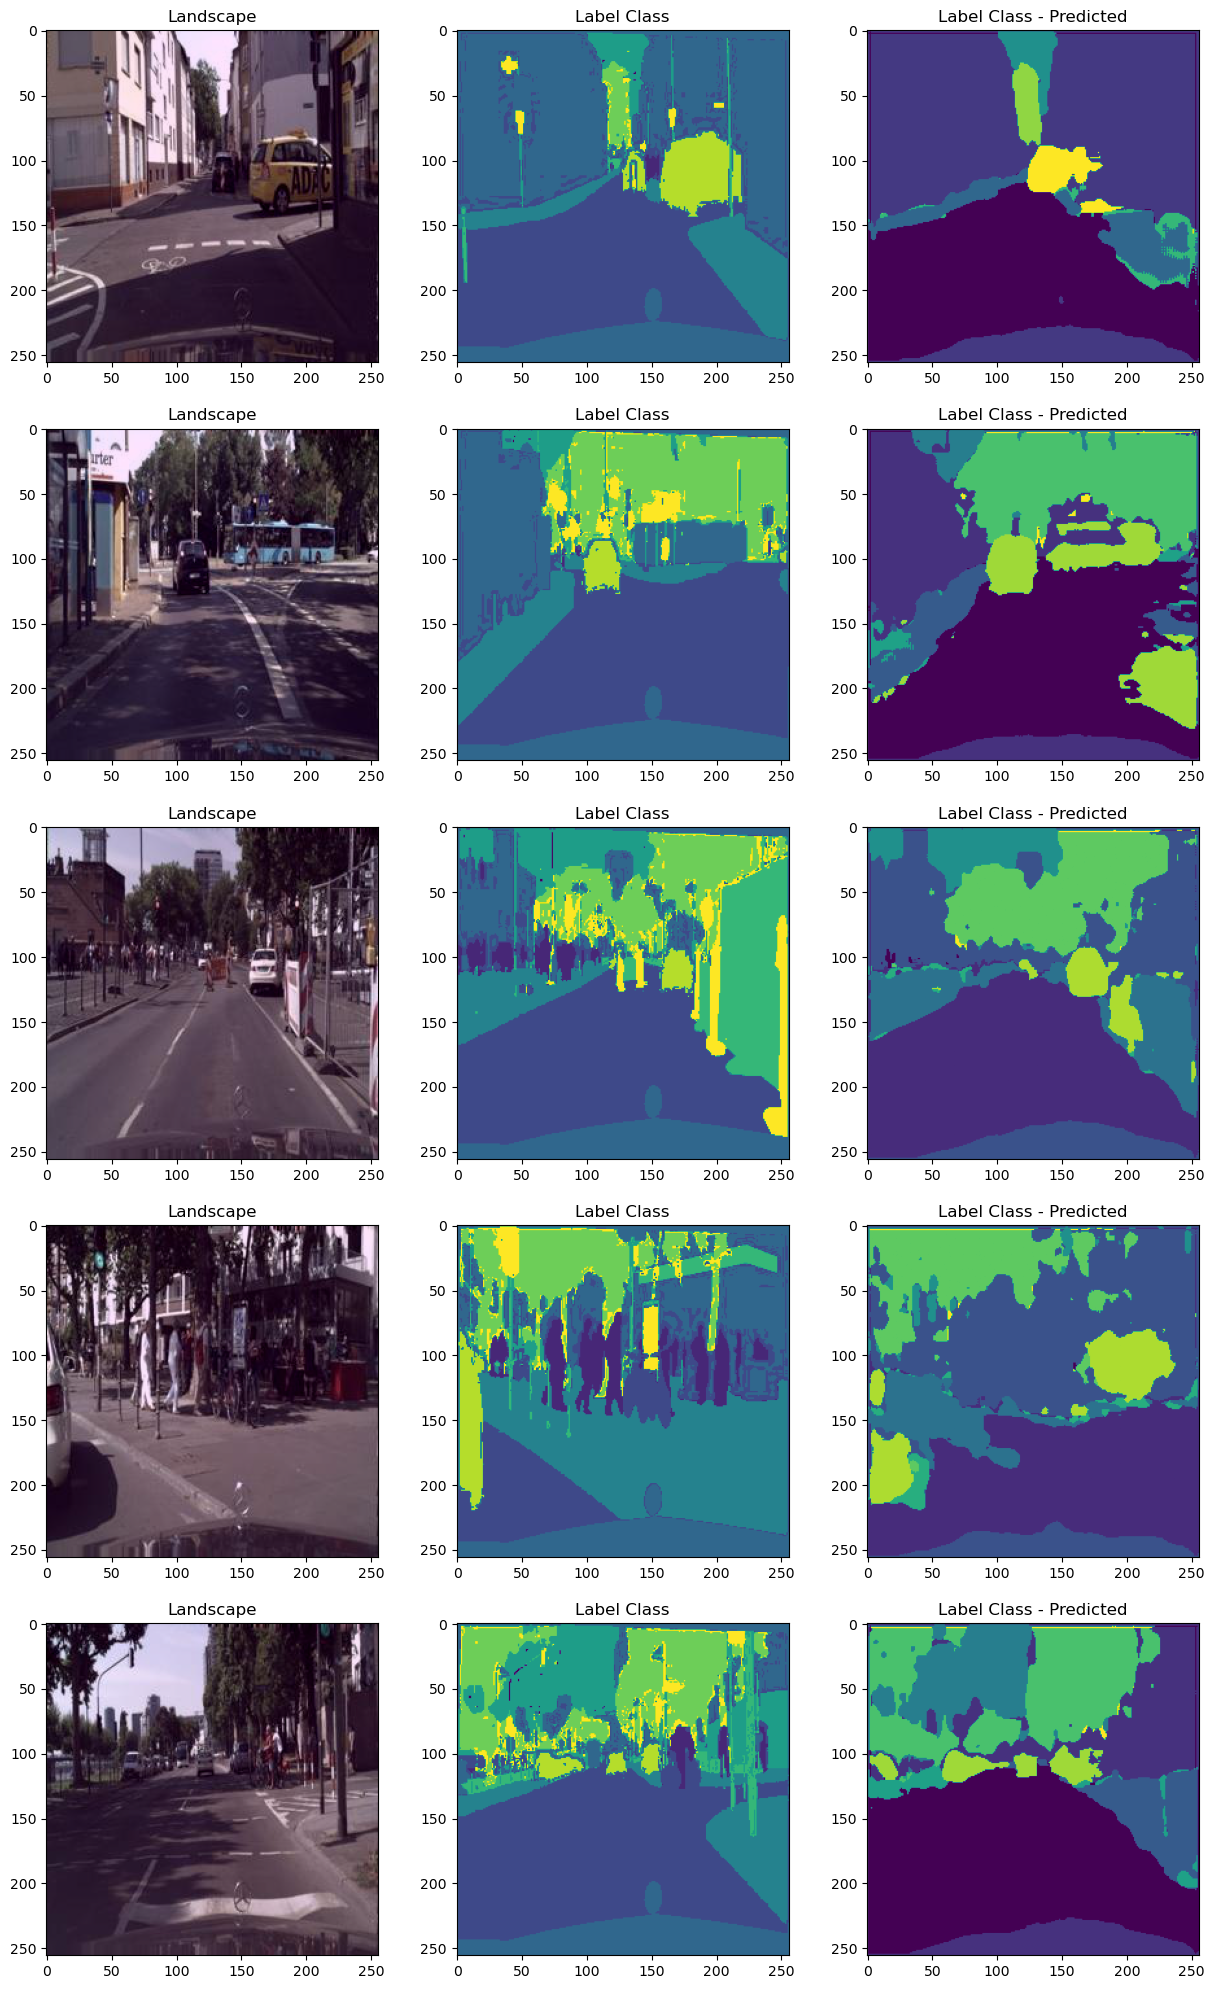

In [57]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")

    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")

    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

## Step 4. IOU Score
Although we can visually observe that the model has done alright, we need to quantify this by providing a metric score. We have these metrics to do just that. I have chosen the mean overall IOU. Finally, we calculate this value. Read more on IOU here.

In [44]:
print(sum(iou_scores) / len(iou_scores))

0.9997978210449219


This shows that the overlap between the actual labels and the predicted outputs. In our case, we get around 97%. Not bad for a first try!

### Final thoughts

The sensitivity of the application domain means that we require much greater accuracy than this. To improve the model further (or to get the whole source code given above), you can have this starter notebook and build upon it.

Do check out 
Gokul Karthik
’s implementation here. Give his repo a visit for some cool Deep Learning projects. This project implements an array of models that tackles semantic segmentation.

A big shoutout to Jovian.ml for the platform to save and embed the notebooks.

In [45]:
# training batch_size = 2, model predictions = 2 ==> 95%
# training batch_sze = 2, model predictions = 8, 10 ==> 88%
# training batch_size = 4, model predictions = 2 => 걸린시간 : 20:06, 99.8%
# training batch_size = 8, model predictions = 2 => 걸린시간 : 17:53, 99%
# training batch_size = 8, model predictions = 4 => 걸린시간 : 17:53, 98%
# training batch_size = 10, model predictions = 2 => 걸린시간 : 17:35, 90%
# training batch_size = 10, model predictions = 4 => 걸린시간 : 17:35, 84.9%